In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import train_test_split

In [11]:
# Define constants
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

In [5]:
data_dir = '100-bird-species'

In [6]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    f'{data_dir}/train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    f'{data_dir}/test',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Print debug information
print(f"Number of training samples: {train_generator.samples}")
print(f"Number of testing samples: {test_generator.samples}")
print(f"Number of classes: {len(train_generator.class_indices)}")
print(f"Class indices: {train_generator.class_indices}")

Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Number of training samples: 84635
Number of testing samples: 2625
Number of classes: 525
Class indices: {'ABBOTTS BABBLER': 0, 'ABBOTTS BOOBY': 1, 'ABYSSINIAN GROUND HORNBILL': 2, 'AFRICAN CROWNED CRANE': 3, 'AFRICAN EMERALD CUCKOO': 4, 'AFRICAN FIREFINCH': 5, 'AFRICAN OYSTER CATCHER': 6, 'AFRICAN PIED HORNBILL': 7, 'AFRICAN PYGMY GOOSE': 8, 'ALBATROSS': 9, 'ALBERTS TOWHEE': 10, 'ALEXANDRINE PARAKEET': 11, 'ALPINE CHOUGH': 12, 'ALTAMIRA YELLOWTHROAT': 13, 'AMERICAN AVOCET': 14, 'AMERICAN BITTERN': 15, 'AMERICAN COOT': 16, 'AMERICAN DIPPER': 17, 'AMERICAN FLAMINGO': 18, 'AMERICAN GOLDFINCH': 19, 'AMERICAN KESTREL': 20, 'AMERICAN PIPIT': 21, 'AMERICAN REDSTART': 22, 'AMERICAN ROBIN': 23, 'AMERICAN WIGEON': 24, 'AMETHYST WOODSTAR': 25, 'ANDEAN GOOSE': 26, 'ANDEAN LAPWING': 27, 'ANDEAN SISKIN': 28, 'ANHINGA': 29, 'ANIANIAU': 30, 'ANNAS HUMMINGBIRD': 31, 'ANTBIRD': 32, 'ANTILLEAN EUPHONIA': 33, 'APAPANE

Original Images:


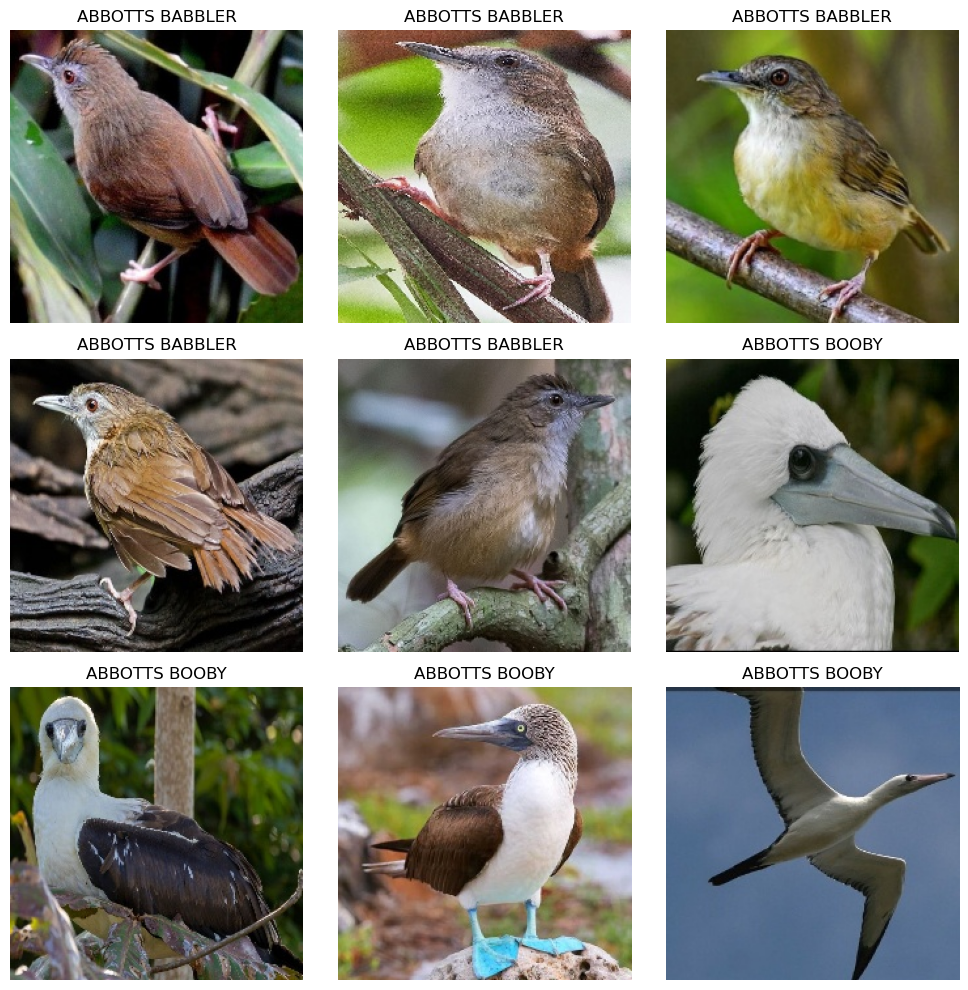

Augmented Images:


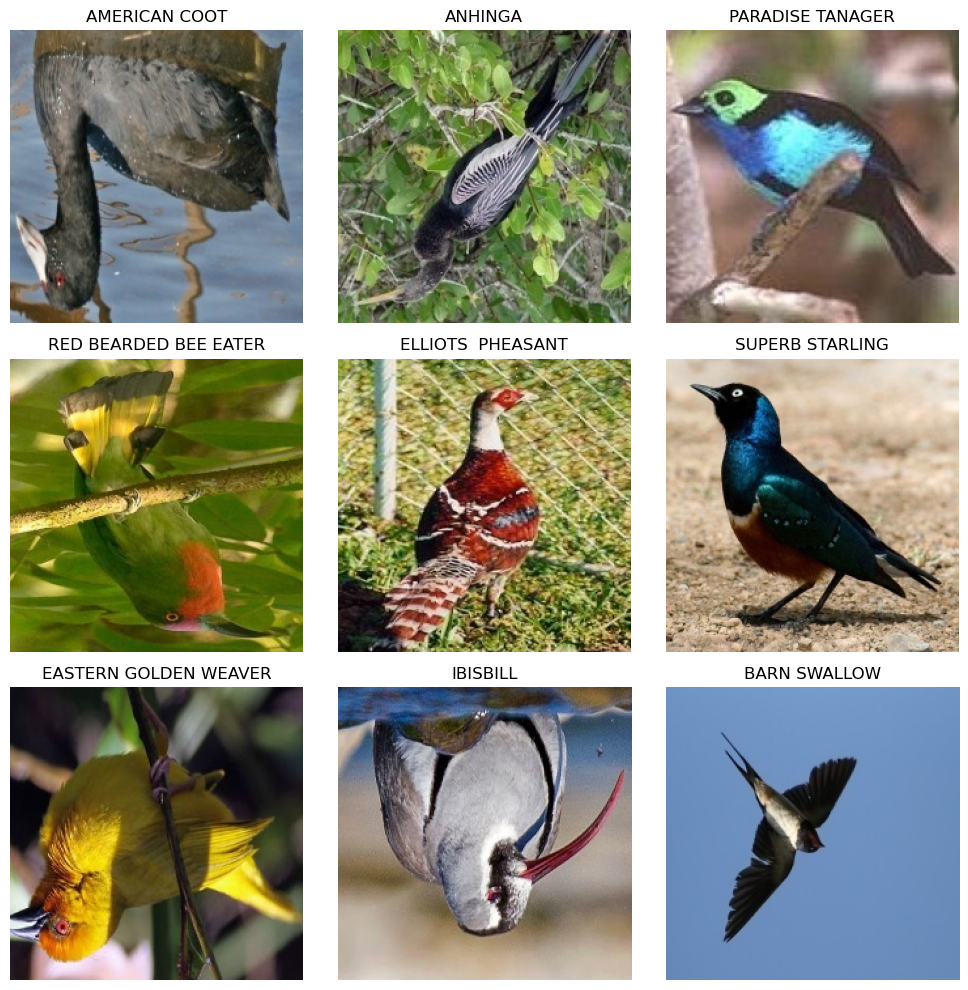

In [7]:
# Visualize some augmented images
def plot_augmented_images(generator, num_images=9):
    images, labels = next(generator)
    classes = list(generator.class_indices.keys())
    
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(classes[np.argmax(labels[i])])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot original and augmented images
print("Original Images:")
plot_augmented_images(test_generator)

print("Augmented Images:")
plot_augmented_images(train_generator)


# Model Building

In [19]:
CLASSES = train_generator.class_indices
NUM_CLASSES = len(CLASS)
SIZE = (IMG_HEIGHT, IMG_WIDTH, 3)

In [8]:
import tensorflow as tf
from tensorflow.keras import layers

def mbconv_block(inputs, filters, kernel_size, strides, expand_ratio, se_ratio, drop_rate):
    # Expansion phase
    x = layers.Conv2D(filters * expand_ratio, 1, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)
    
    # Depthwise Convolution
    x = layers.DepthwiseConv2D(kernel_size, strides=strides, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)
    
    # Squeeze and Excitation
    se = layers.GlobalAveragePooling2D()(x)
    se = layers.Dense(max(1, int(filters * se_ratio)), activation='swish')(se)
    se = layers.Dense(filters * expand_ratio, activation='sigmoid')(se)
    x = layers.Multiply()([x, se])
    
    # Output phase
    x = layers.Conv2D(filters, 1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    
    # Dropout and Skip Connection
    if strides == 1 and inputs.shape[-1] == filters:
        if drop_rate > 0:
            x = layers.Dropout(drop_rate)(x)
        x = layers.Add()([x, inputs])
    
    return x

def fused_mbconv_block(inputs, filters, kernel_size, strides, expand_ratio, drop_rate):
    # Fused convolution
    x = layers.Conv2D(filters * expand_ratio, kernel_size, strides=strides, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)
    
    # Output phase
    x = layers.Conv2D(filters, 1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    
    # Dropout and Skip Connection
    if strides == 1 and inputs.shape[-1] == filters:
        if drop_rate > 0:
            x = layers.Dropout(drop_rate)(x)
        x = layers.Add()([x, inputs])
    
    return x

In [9]:
def build_efficientnetv2_s(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    # Stem
    x = layers.Conv2D(24, 3, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)
    
    # Blocks configuration: (filters, kernel_size, strides, expand_ratio, se_ratio, repeats)
    blocks = [
        (24, 3, 1, 1, 0, 2),  # Fused-MBConv1, 2 blocks
        (48, 3, 2, 4, 0, 4),  # Fused-MBConv4, 4 blocks
        (64, 3, 2, 4, 0, 4),  # Fused-MBConv4, 4 blocks
        (128, 3, 2, 4, 0.25, 6),  # MBConv6, 6 blocks
        (160, 3, 1, 6, 0.25, 9),  # MBConv6, 9 blocks
        (256, 3, 2, 6, 0.25, 15)  # MBConv6, 15 blocks
    ]
    
    # Build the blocks
    for filters, kernel_size, strides, expand_ratio, se_ratio, repeats in blocks:
        for i in range(repeats):
            if i == 0:
                if se_ratio > 0:
                    x = mbconv_block(x, filters, kernel_size, strides, expand_ratio, se_ratio, drop_rate=0.2)
                else:
                    x = fused_mbconv_block(x, filters, kernel_size, strides, expand_ratio, drop_rate=0.2)
            else:
                if se_ratio > 0:
                    x = mbconv_block(x, filters, kernel_size, 1, expand_ratio, se_ratio, drop_rate=0.2)
                else:
                    x = fused_mbconv_block(x, filters, kernel_size, 1, expand_ratio, drop_rate=0.2)
    
    # Head
    x = layers.Conv2D(1280, 1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    # Model
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [22]:
effnet = build_efficientnetv2_s(SIZE, NUM_CLASSES)

# Print the model summary
effnet.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_246 (Conv2D) │ (None, 112, 112,  │        648 │ input_layer_3[0]… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │         96 │ conv2d_246[0][0]  │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_216      │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_247 (Conv2D) │ (None, 112, 112,  │      5,184 │ activation_216[0… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │         96 │ conv2d_247[0][0]  │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_217      │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_248 (Conv2D) │ (None, 112, 112,  │        576 │ activation_217[0… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │         96 │ conv2d_248[0][0]  │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_108         │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Dropout)           │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_105 (Add)       │ (None, 112, 112,  │          0 │ dropout_108[0][0… │
│                     │ 24)               │            │ activation_216[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_249 (Conv2D) │ (None, 112, 112,  │      5,184 │ add_105[0][0]     │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │         96 │ conv2d_249[0][0]  │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_218      │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_250 (Conv2D) │ (None, 112, 112,  │        576 │ activation_218[0… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │         96 │ conv2d_250[0][0]  │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_109         │ (None, 112, 112,  │          0 │ batch_normalizat

 Total params: 21,597,533 (82.39 MB)

 Trainable params: 21,439,149 (81.78 MB)

 Non-trainable params: 158,384 (618.69 KB)

## Functions

In [27]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = ['accuracy']

In [28]:
effnet.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)

## Train

In [29]:
history = effnet.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10
)

Epoch 1/10


2024-08-13 13:19:27.027330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/Users/wyattcheang/harmful_insect_model/env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 110/2645 ━━━━━━━━━━━━━━━━━━━━ 11:55:59 17s/step - accuracy: 0.0044 - loss: 6.4124